In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
from scipy.optimize import curve_fit
from pathlib import Path
from ndlattice import mdlattice, second_excitation_energies, second_excitation_energies_spins
from matrixensembles import GOEsampler, MatrixStats, Betasampler, LatticeSampler, PalHuseSelector
from lmfit import minimize, Model

output_dir = Path('../out/multidimensional/onedimensional/')

def paramstring(params, type='file'):
	if type == 'plot':
		return " ".join([f"{k}={v}" for k, v in params.items()])
	elif type == 'file':
		return "-".join([f"{k}{v}" for k, v in params.items()])
	elif type=='metadata':
		metadata = {}
		for k, v in params.items():
			metadata[k] = str(v)
		return metadata
	else:
		raise ValueError(f"Unknown type {type}")

def poissonweights(heights, norm=1):
	sigma = np.sqrt(heights/norm)
	sigma[sigma==0] = 1/norm
	return 1/sigma

# set default plot size to 720p
# plt.rcParams['figure.figsize'] = [1280/96, 720/96]

In [12]:
wignerdyson = lambda s: np.pi/2 * s * np.exp(-np.pi/4 * np.square(s))
expo = lambda x, A, D: A*np.exp(-x / D)

def expo2(s, A, B):
	return A * np.pi * s/2 * np.exp(-np.pi * np.square(s) * B /4)


mod_expo = Model(expo)
mod_expo2 = Model(expo2)
mod_wignerdyson = Model(wignerdyson)

In [ ]:
n_it = 100
e_l = []
s_l = []
d, n, w0 = 3, 10, 100
W, t = 2, 1
N = n**d
K = 0
EXCITATIONS = 1
TYPE = 'oscillators'
for it in trange(n_it):
	if EXCITATIONS == 1:
		m = mdlattice(d, n, W, t, w0)
		ev = np.linalg.eigvalsh(m)
		e_l.append(ev)
		s_l.append(s:=np.diff(ev))
		if np.any(s < 0):
			raise RuntimeError("Negative spacing found! Eigenenergies were not sorted.")
	elif EXCITATIONS == 2:
		m = mdlattice(d, n, W, t)
		if TYPE == 'oscillators':
			e_l.append(second_excitation_energies(m, K))
			s_l.append(s:=np.diff(second_excitation_energies(m, K)))
		elif TYPE == 'spins':
			e_l.append(second_excitation_energies_spins(m))
			s_l.append(s:=np.diff(second_excitation_energies_spins(m)))
		else:
			raise ValueError("Invalid TYPE")
	else:
		raise ValueError("Invalid EXCITATIONS")


energies = np.concatenate(e_l)
spacings = np.concatenate(s_l)
s_scaled = spacings / np.mean(spacings)


### Finite-size effects

In [ ]:
n_it = 1
d, w0 = 3, 100
W, t = 30, 1
s_n = {}
EXCITATIONS = 1
TYPE = 'oscillators'
for n, n_it in [(5, 2000), (10, 40), (17, 4)]:
	e_l = []
	s_l = []
	for it in trange(n_it):
		m = mdlattice(d, n, W, t, w0)
		ev = np.linalg.eigvalsh(m)
		e_l.append(ev)
		s_l.append(s:=np.diff(ev))
	s_n[n] = np.concatenate(s_l)

 25%|██▌       | 1/4 [00:35<01:45, 35.25s/it]


KeyboardInterrupt: 

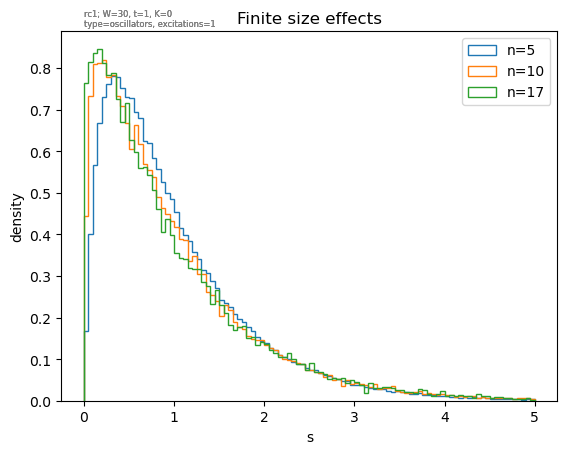

In [ ]:
for n, s in s_n.items():
	scaled = s / np.mean(s)
	plt.hist(scaled, bins=100, density=True, label=f'n={n}', histtype='step', range=(0, 5))
	plt.xlabel(r"s")
	plt.ylabel("density")
	plt.legend()
	plt.text(0, 0.9, paramstring(W, t, K, TYPE, EXCITATIONS, 'plot'), fontsize=6, color='gray')
	plt.title("Finite size effects")
	plt.savefig(output_dir / f"finite_size_effects_{paramstring(W, t, K, TYPE, EXCITATIONS)}.pdf")

### Oganesyan and Huse

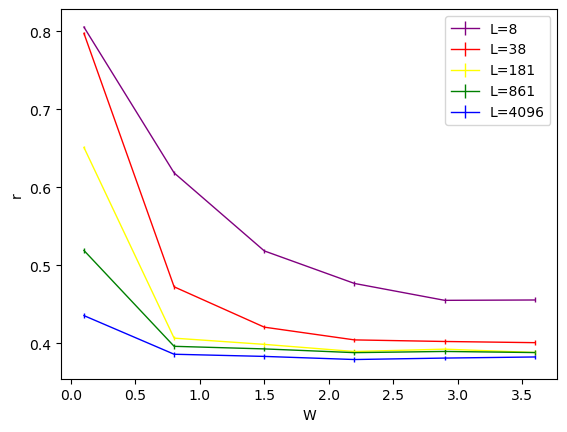

In [48]:
c = iter(["purple", "red", "yellow", "green", "blue", "cyan", "orange", "gray", "black", "pink"])
# restore default plot size

for L, (corr_W, corr_r, corr_err) in correlation_results.items():
	plt.errorbar(corr_W, corr_r, yerr=corr_err, label=f'L={L}', fmt='-', color=next(c))

plt.legend()
plt.xlabel("W")
plt.ylabel("r")
plt.savefig(output_dir / f"correlation_transition.pgf")
plt.savefig(output_dir / f"correlation_transition.png", dpi=300)

In [47]:
d, n, w0 = 1, 16**3, 100
W, t = 3, 1
TYPE='oscillators'

def correlation_transition(corr_W, d, n, t, w0):
	corr_r, corr_err = np.zeros_like(corr_W, dtype=np.float64), np.zeros_like(corr_W, dtype=np.float64)
	for i, W in enumerate(corr_W):
		matrixstats = MatrixStats(LatticeSampler(d, n, W, t, w0, torus=False))
		matrixstats.collect(10**4)
		r = matrixstats.d2correlations().flat
		r_avg = np.mean(r) # average over disorder and states
		corr_r[i] = r_avg
		corr_err[i] = np.std(r) / np.sqrt(len(r))
	return corr_W, corr_r, corr_err

correlation_results = {}
for i, L in enumerate(np.around(np.logspace(np.log10(8), np.log10(n), 5)).astype(np.int64)):
	corr_W = np.arange(0.1, 4, 0.7)
	corr_W, corr_r, corr_err = correlation_transition(corr_W, d, L, t, w0)
	correlation_results[L] = (corr_W, corr_r, corr_err)

100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


### Fit the tail

In [67]:
d, n, w0 = 3, 16, 1000
W, t = 1, 1
TYPE='oscillators'
matrixstats = MatrixStats(LatticeSampler(d, n, W, t, w0))
matrixstats.collect(10**5)

100%|██████████| 24/24 [00:52<00:00,  2.17s/it]


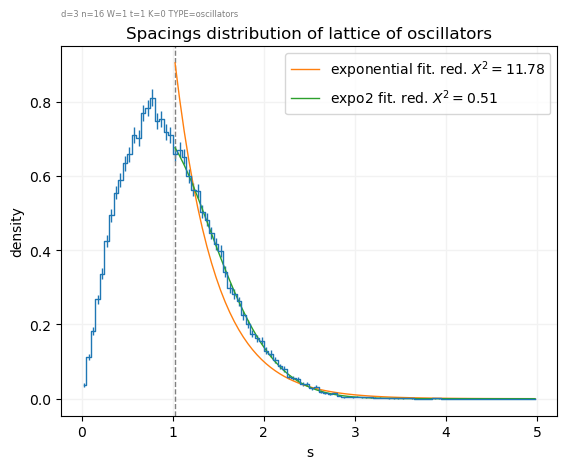

In [68]:
K = 0
heights, borders = np.histogram(matrixstats.s(PalHuseSelector).flat, bins=100, range=(0, 5))
norm = np.sum(heights) * np.diff(borders)[0]
heights = heights / norm
weights = poissonweights(heights, norm=norm)
centers = borders[:-1] + np.diff(borders) / 2
starti = int(len(centers) * .2)
x, y, w = centers[starti:], heights[starti:], weights[starti:]
res_expo = mod_expo.fit(y, x=x, A=1, D=1, weights=w)
res_wd = mod_wignerdyson.fit(y, s=x, weights=w)
res_expo2 = mod_expo2.fit(y, s=x, A=1, B=1, weights=w)

plt.xlabel(r"s")
plt.ylabel("density")
# plt.ylim(0, 0.85)

# plt.plot(centers, wignerdyson(centers, 0), label="Wigner-Dyson")
plt.errorbar(
    centers,
    heights,
    yerr = 1/weights,
    marker = '.',
    markersize = 0,
    drawstyle = 'steps-mid'
)
plt.axvline(centers[starti], color='gray', linestyle='--')

plt.plot(centers[starti:], res_expo.best_fit, label=f"exponential fit. red. $X^2={res_expo.redchi:.2f}$")
plt.plot(centers[starti:], res_expo2.best_fit, label=f"expo2 fit. red. $X^2={res_expo2.redchi:.2f}$")
# plt.plot(centers, res_wd.eval(s=centers), label=f"wigner-dyson red. $X^2={res_wd.redchi:.2f}$", lw=0.5, color='gray')
# add a grid of very light gray color
plt.grid(color='0.95', linestyle='-', linewidth=1)
plt.legend()
plt.title("Spacings distribution of lattice of oscillators")
params = dict(d=d, n=n, W=W, t=t, K=K, TYPE=TYPE)
plt.text(0, 1.10, paramstring(params, 'plot'), fontsize=6, color='gray', transform=plt.gca().transAxes, verticalalignment='top')

plt.savefig(output_dir / f'fit_{paramstring(params, "file")}.png')
plt.savefig(output_dir / f'fit_{paramstring(params, "file")}.pgf')
plt.show()

In [ ]:

res_expo2.params

name,value,standard error,relative error,initial value,min,max,vary
A,0.83339561,0.01405896,(1.69%),1,-inf,inf,True
B,0.91708988,0.00787624,(0.86%),1,-inf,inf,True


In [ ]:
res_wd.eval(s=centers).shape

(100,)